# Setup

## Install

In [1]:
!pip install -U langchain langchain-community langchain-core langchain-openai langgraph faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.4
    Uninstalling langchain-0.3.4:
      Successfully uninstalled langchain-0.3.4


## OpenAI Key 등록
- [OpenAI Key 발급방법](https://platform.openai.com/api-keys)
- [OpenAI 요금](https://openai.com/api/pricing/)

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = ''

## 구글 드라이브 연결(데이터 로드를 위해서)

In [3]:
# 구글 드라이브 연결(데이터 로드를 위해서)

try:
    from google.colab import drive

    drive.mount('/content/data')
    DATA_PATH = "/content/data/MyDrive/ai_lecture/3. Large Language Models/data/"
except:

    DATA_PATH = "./data/"

Mounted at /content/data


# [Chains](https://python.langchain.com/docs/versions/migrating_chains/)

## [LLMChain](https://python.langchain.com/docs/versions/migrating_chains/llm_chain/)

### Prompt

In [4]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages(
    [("user", "Tell me a {adjective} joke")],
)

### Chain

In [5]:
chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()

### Run Chain

In [6]:
response = chain.invoke({"adjective": "funny"})

In [9]:
print(response)

Why don't skeletons fight each other? 

They don't have the guts!


## [ConversationalChain](https://python.langchain.com/docs/versions/migrating_chains/conversation_chain/)

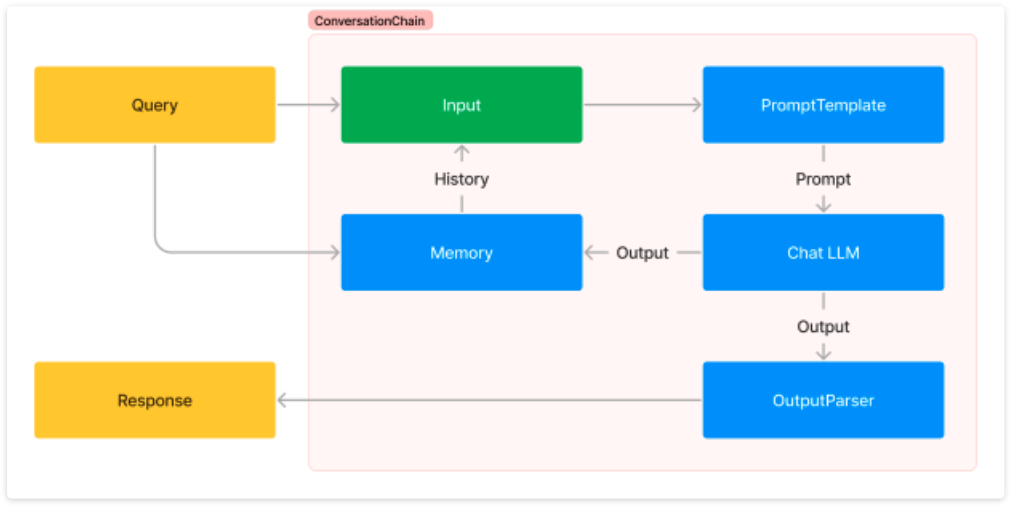

### LLM

In [10]:
import uuid

from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage

model = ChatOpenAI(model="gpt-4o-mini")

### Node

In [11]:
# Define the function that calls the model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}

### [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph)

In [12]:
# Define a new graph
workflow = StateGraph(state_schema=MessagesState)

# Define the two nodes we will cycle between
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

### [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver)
- An in-memory checkpoint saver.

In [13]:
# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

### display

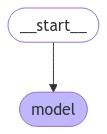

In [14]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

### app

In [15]:
# The thread id is a unique key that identifies
# this particular conversation.
# We'll just generate a random uuid here.
thread_id = uuid.uuid4()

thread_id

UUID('614388be-0682-40f6-97fb-ba8b933c2b73')

In [16]:
thread_id = uuid.uuid4()

thread_id

UUID('12df27fc-5388-4ada-87ee-3ea58dd65e5e')

In [17]:
config = {"configurable": {"thread_id": thread_id}}


- The mode to stream output, defaults to self.stream_mode.
- Options are 'values', 'updates', and 'debug'.
  - `values`: Emit the current values of the state for each step.
  - `updates`: Emit only the updates to the state for each step. Output is a dict with the node name as key and the updated values as value.
  - `debug`: Emit debug events for each step.

In [18]:
stream_mode="values"

In [19]:
query = "제 이름은 홍길동입니다."
input_messages = [
    SystemMessage("당신은 선생님입니다."),
    HumanMessage(query)
]

In [20]:
response = app.stream({"messages": input_messages}, config, stream_mode=stream_mode)
for event in response:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

제 이름은 홍길동입니다.
================================== Ai Message ==================================

안녕하세요, 홍길동님! 만나서 반갑습니다. 어떻게 도와드릴까요?


In [21]:
input_messages = [HumanMessage("제 이름은 뭔가요?")]
response = app.stream({"messages": input_messages}, config, stream_mode=stream_mode)
for event in response:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

제 이름은 뭔가요?
================================== Ai Message ==================================

홍길동님이라고 말씀하셨습니다. 맞나요? 추가로 궁금한 점이 있으시면 말씀해 주세요!


In [22]:
stream_mode="debug"

In [26]:
input_messages = [HumanMessage("대한민국의 수도는 어디인가요?")]
response = app.stream({"messages": input_messages}, config, stream_mode=stream_mode)

In [27]:
event = next(iter(response))

In [28]:
event.keys()

dict_keys(['type', 'timestamp', 'step', 'payload'])

In [30]:
event['step']

6

In [31]:
event['type']

'checkpoint'

In [32]:
event['timestamp']

'2024-11-01T03:18:47.719202+00:00'

In [33]:
event['payload']

{'config': {'tags': [],
  'metadata': ChainMap({}),
  'callbacks': None,
  'recursion_limit': 25,
  'configurable': {'checkpoint_ns': '',
   'thread_id': UUID('12df27fc-5388-4ada-87ee-3ea58dd65e5e'),
   'checkpoint_id': '1ef98000-243c-650b-8006-99bab3bc4584'}},
 'parent_config': {'tags': [],
  'metadata': ChainMap({}),
  'callbacks': None,
  'recursion_limit': 25,
  'configurable': {'checkpoint_ns': '',
   'thread_id': UUID('12df27fc-5388-4ada-87ee-3ea58dd65e5e'),
   'checkpoint_id': '1ef97ffd-a8cf-66ca-8005-1ac1b9f463fa'}},
 'values': {'messages': [SystemMessage(content='당신은 선생님입니다.', additional_kwargs={}, response_metadata={}, id='b676965a-9182-4885-9437-1c742678b825'),
   HumanMessage(content='제 이름은 홍길동입니다.', additional_kwargs={}, response_metadata={}, id='f4ff0c2e-6d4e-4915-9bab-2fb849491a50'),
   AIMessage(content='안녕하세요, 홍길동님! 만나서 반갑습니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 27, 'total_token

In [34]:
stream_mode="updates"

In [35]:
input_messages = [HumanMessage("외국인에게 추천할 한국음식 하나만 추천해줘?")]
response = app.stream({"messages": input_messages}, config, stream_mode=stream_mode)

In [36]:
response

<generator object Pregel.stream at 0x7e427439a570>

In [37]:
event = next(iter(response))

In [38]:
event

{'model': {'messages': AIMessage(content='외국인에게 추천할 한국 음식으로 **비빔밥**을 추천합니다. 비빔밥은 다양한 재료가 조화를 이루는 맛있는 요리로, 고추장과 함께 비벼 먹으면 풍부한 맛을 즐길 수 있습니다. 또한, 채소와 고기를 함께 즐길 수 있어 영양가도 높습니다. 비빔밥은 색감도 아름다워 시각적으로도 매력적이어서 외국인에게 좋은 인상을 줄 수 있을 것입니다!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 112, 'prompt_tokens': 113, 'total_tokens': 225, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-d3f9aa8d-2559-4411-a245-3bb23a43956b-0', usage_metadata={'input_tokens': 113, 'output_tokens': 112, 'total_tokens': 225, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})}}

In [39]:
event['model']['messages'].pretty_print()

================================== Ai Message ==================================

외국인에게 추천할 한국 음식으로 **비빔밥**을 추천합니다. 비빔밥은 다양한 재료가 조화를 이루는 맛있는 요리로, 고추장과 함께 비벼 먹으면 풍부한 맛을 즐길 수 있습니다. 또한, 채소와 고기를 함께 즐길 수 있어 영양가도 높습니다. 비빔밥은 색감도 아름다워 시각적으로도 매력적이어서 외국인에게 좋은 인상을 줄 수 있을 것입니다!


## [RetrievalQA](https://python.langchain.com/docs/versions/migrating_chains/retrieval_qa/)

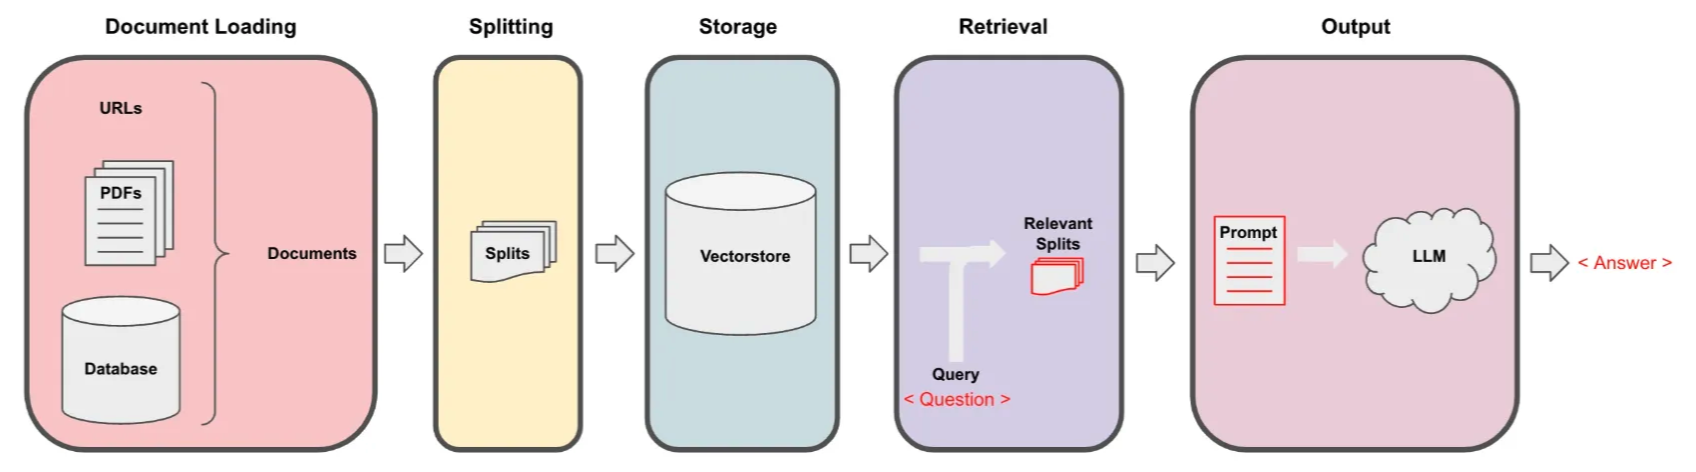

### Retrieval

In [49]:
# Load docs
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 문서를 로드하는 객체
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")

# load()함수를 통해서 데이터를 메모리에 로드
data = loader.load()

In [50]:
len(data)

1

In [51]:
data[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content='\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autono

In [52]:
data[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:',
 'language': 'en'}

In [53]:
data[0].page_content

'\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation\n\nProof-of-Concept Examples\n\n\nChallenges\n\nCitation\n\nReferences\n\n\n\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as ins

In [54]:
print(data[0].page_content)







LLM Powered Autonomous Agents | Lil'Log







































Lil'Log






















Posts




Archive




Search




Tags




FAQ




emojisearch.app









      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


 


Table of Contents



Agent System Overview

Component One: Planning

Task Decomposition

Self-Reflection


Component Two: Memory

Types of Memory

Maximum Inner Product Search (MIPS)


Component Three: Tool Use

Case Studies

Scientific Discovery Agent

Generative Agents Simulation

Proof-of-Concept Examples


Challenges

Citation

References





Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general

In [55]:
# Splitter 객체
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)

# 문서 분리
all_splits = text_splitter.split_documents(data)

In [56]:
len(all_splits)

131

In [57]:
all_splits[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content="LLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n 

In [58]:
all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:',
 'language': 'en'}

In [59]:
all_splits[0].page_content

"LLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)"

In [60]:
len(all_splits[0].page_content)

492

In [61]:
# Store splits
vectorstore = FAISS.from_documents(documents=all_splits, embedding=OpenAIEmbeddings())

### LLM

In [62]:
# LLM
llm = ChatOpenAI(model="gpt-4o-mini")

### LCEL

In [63]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# See full prompt at https://smith.langchain.com/hub/rlm/rag-prompt
prompt = hub.pull("rlm/rag-prompt")

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [64]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [65]:
prompt.input_variables

['context', 'question']

In [66]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


qa_chain = (
    {
        # context <-> retriever(vectorstore 유사한 데이터들 추출)
        # -> format_docs(데이터들 중에서 텍스트 데이터만 하나의 문장으로 변환해서 전달)
        "context": vectorstore.as_retriever() | format_docs,
        # question <-> Passthrough
        "question": RunnablePassthrough(),
    }
    | prompt
    | llm
    | StrOutputParser()
)

In [67]:
response = qa_chain.invoke("What are autonomous agents?")

In [68]:
response

'Autonomous agents are systems capable of independently performing tasks, such as scientific experiments, by utilizing tools like the Internet and APIs. They can plan, decompose tasks, and execute complex workflows without human intervention. An example includes LLM-powered agents that can suggest and reason through steps to develop new drugs.'

### RAG

In [69]:
from langchain import hub
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

# See full prompt at https://smith.langchain.com/hub/langchain-ai/retrieval-qa-chat
retrieval_qa_chat_prompt = hub.pull("langchain-ai/retrieval-qa-chat")

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [70]:
retrieval_qa_chat_prompt

ChatPromptTemplate(input_variables=['context', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMes

In [71]:
retrieval_qa_chat_prompt.input_variables

['context', 'input']

In [72]:
combine_docs_chain = create_stuff_documents_chain(llm, retrieval_qa_chat_prompt)

In [73]:
rag_chain = create_retrieval_chain(vectorstore.as_retriever(), combine_docs_chain)

res = rag_chain.invoke({"input": "What are autonomous agents?"})

In [74]:
res.keys()

dict_keys(['input', 'context', 'answer'])

In [75]:
res['input']

'What are autonomous agents?'

In [76]:
res['answer']

'Autonomous agents are systems that can independently perform tasks without human intervention. They utilize advanced technologies, such as large language models (LLMs), to manage complex processes like planning, executing experiments, and making decisions. These agents can browse the Internet, read documentation, execute code, and utilize various APIs to complete their objectives, making them capable of handling intricate and multifaceted tasks such as scientific discovery and experimentation.'

In [77]:
res['context']

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content='Boiko et al. (2023) also looked into LLM-empowered agents for scientific discovery, to handle autonomous design, planning, and performance of complex scientific experiments. This agent can use tools to browse the Internet, read documentation, execute code, call robotics experimentation APIs and leverage other LLMs.\nF

## [ConversationalRetrievalChain](https://python.langchain.com/docs/versions/migrating_chains/conversation_retrieval_chain/)

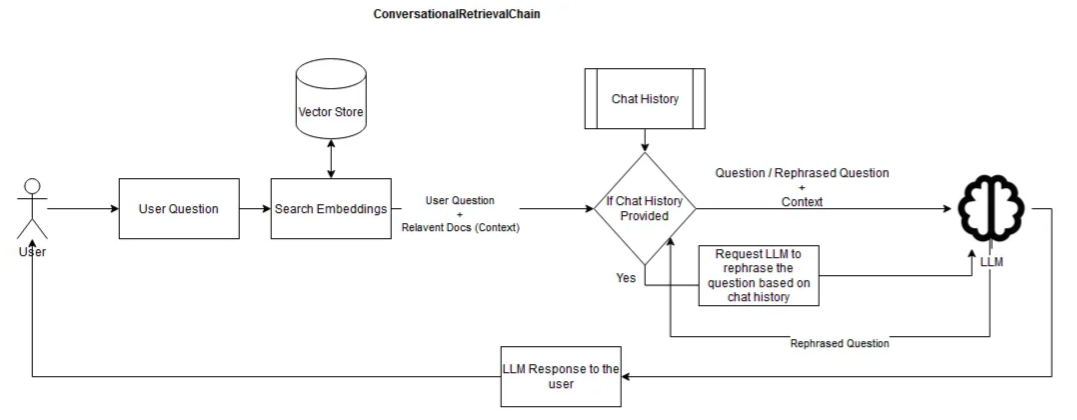

### Retrieval

In [78]:
# Load docs
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()


In [79]:
len(data)

1

In [ ]:
# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
all_splits = text_splitter.split_documents(data)


In [ ]:
all_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content="LLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n

In [ ]:
# Store splits
vectorstore = FAISS.from_documents(documents=all_splits, embedding=OpenAIEmbeddings())

### LLM

In [ ]:
# LLM
llm = ChatOpenAI(model="gpt-4o-mini")

### LCEL

In [ ]:
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

In [ ]:
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
    ]
)

qa_chain = create_stuff_documents_chain(llm, qa_prompt)

In [ ]:
condense_question_system_template = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

condense_question_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", condense_question_system_template),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
    ]
)

history_aware_retriever = create_history_aware_retriever(
    llm, vectorstore.as_retriever(), condense_question_prompt
)

In [ ]:
convo_qa_chain = create_retrieval_chain(history_aware_retriever, qa_chain)

response = convo_qa_chain.invoke(
    {
        "input": "What are autonomous agents?",
        "chat_history": [],
    }
)

In [ ]:
response.keys()

dict_keys(['input', 'chat_history', 'context', 'answer'])

In [ ]:
response['answer']

'Autonomous agents are systems that can perform tasks independently, often using advanced technologies like artificial intelligence and machine learning. They can plan, make decisions, and execute actions without human intervention, which allows them to handle complex processes such as scientific experiments. An example of this is LLM-empowered agents that can browse the Internet, execute code, and leverage other models for tasks like drug development.'

## [StuffDocumentsChain](https://python.langchain.com/docs/versions/migrating_chains/stuff_docs_chain/)
-  이 방법은 분할할 필요가 없는 짧은 문서 전체를 프롬프트에 넣어 LLM에 전달하는 방법입니다.
- 간단하고 API를 한 번만 호출하면 되지만, 문서 길이가 길어지면 사용할 수 없는 방법입니다.

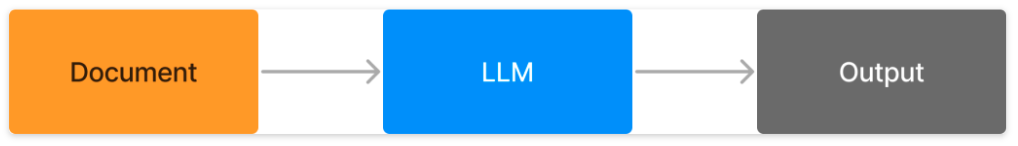

### LLM

In [80]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

### Document

In [81]:
from langchain_core.documents import Document

documents = [
    Document(page_content="Apples are red", metadata={"title": "apple_book"}),
    Document(page_content="Blueberries are blue", metadata={"title": "blueberry_book"}),
    Document(page_content="Bananas are yelow", metadata={"title": "banana_book"}),
]

In [82]:
documents

[Document(metadata={'title': 'apple_book'}, page_content='Apples are red'),
 Document(metadata={'title': 'blueberry_book'}, page_content='Blueberries are blue'),
 Document(metadata={'title': 'banana_book'}, page_content='Bananas are yelow')]

### LCEL

In [83]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template("Summarize this content: {context}")
chain = create_stuff_documents_chain(llm, prompt)

In [85]:
prompt

ChatPromptTemplate(input_variables=['context'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], input_types={}, partial_variables={}, template='Summarize this content: {context}'), additional_kwargs={})])

In [84]:
result = chain.invoke({"context": documents})
result

'The content describes the colors of different fruits: apples are red, blueberries are blue, and bananas are yellow.'

In [ ]:
for chunk in chain.stream({"context": documents}):
    print(chunk, end=" | ")

 | The |  content |  describes |  the |  colors |  of |  three |  fruits | : |  apples |  are |  red | , |  blueberries |  are |  blue | , |  and |  bananas |  are |  yellow | . |  | 

## [RefineDocumentsChain](https://python.langchain.com/docs/versions/migrating_chains/refine_docs_chain/)
- Refine 방법을 이용해 4개의 chunk로 나눠진 문서를 요약하는 과정을 생각해봅시다.
  - 우선 1번 chunk를 요약합니다.
  - 1번 요약에 2번 chunk를 더한 내용을 요약합니다.
  - 1+2번 요약에 3번 chunk를 더한 내용을 요약합니다.
  - 1+2+3번 요약에 4번 chunk를 더한 내용을 요약합니다. 이 내용이 최종 결과가 됩니다.
  
이 방법은 문서의 맥락을 유지하며 긴 문서를 요약할 수 있는 방법이지만, Stuff 방법에 비하면 API 호출 횟수가 많습니다. 또한 LLM을 순차적으로 호출해야 하므로 전체 작업 시간이 길어지게 됩니다.

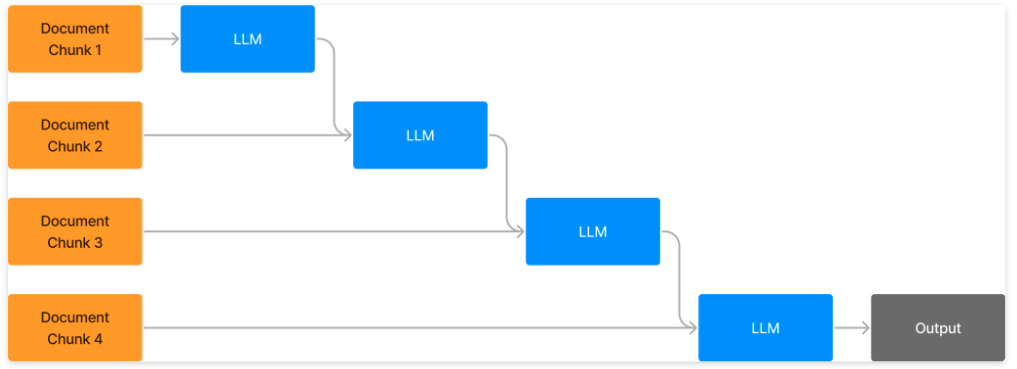

In [86]:
import operator
from typing import List, Literal, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

### Document

In [87]:
from langchain_core.documents import Document

documents = [
    Document(page_content="Apples are red", metadata={"title": "apple_book"}),
    Document(page_content="Blueberries are blue", metadata={"title": "blueberry_book"}),
    Document(page_content="Bananas are yelow", metadata={"title": "banana_book"}),
]

In [88]:
documents

[Document(metadata={'title': 'apple_book'}, page_content='Apples are red'),
 Document(metadata={'title': 'blueberry_book'}, page_content='Blueberries are blue'),
 Document(metadata={'title': 'banana_book'}, page_content='Bananas are yelow')]

### LLM

In [89]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### initial_summary_chain

In [90]:
# Initial summary
summarize_prompt = ChatPromptTemplate(
    [
        ("human", "Write a concise summary of the following: {context}"),
    ]
)
initial_summary_chain = summarize_prompt | llm | StrOutputParser()

In [91]:
# For LangGraph, we will define the state of the graph to hold the query,
# destination, and final answer.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str


# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}

### refine_summary_chain

In [92]:
# Refining the summary with new docs
refine_template = """
Produce a final summary.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm | StrOutputParser()

In [94]:
# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"

### StateGraph

In [95]:
graph = StateGraph(State)

graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)
graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)

app = graph.compile()

### display

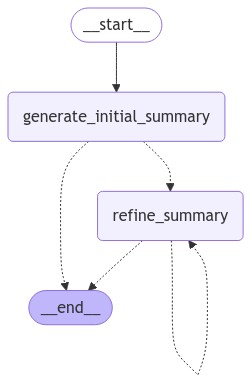

In [96]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

### app

In [ ]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in documents]},
    stream_mode="values",
):
    if summary := step.get("summary"):
        print(summary)

Apples are typically red in color.
Apples are typically red in color, while blueberries are blue.
Apples are typically red in color, blueberries are blue, and bananas are yellow.


In [ ]:
async for event in app.astream_events(
    {"contents": [doc.page_content for doc in documents]}, version="v2"
):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            print(content, end="|")
    elif kind == "on_chat_model_end":
        print("\n\n")

Ap|ples| are| characterized| by| their| red| color|.|


Ap|ples| are| characterized| by| their| red| color|,| while| blueberries| are| known| for| their| blue| hue|.|


Ap|ples| are| characterized| by| their| red| color|,| blueberries| are| known| for| their| blue| hue|,| and| bananas| are| recognized| for| their| yellow| color|.|




## [MapReduceDocumentsChain](https://python.langchain.com/docs/versions/migrating_chains/map_reduce_chain/)
- Map Reduce 방법을 이용해 4개의 chunk로 나눠진 문서를 요약하는 과정을 생각해봅시다.
  - `Map`: 1번부터 4번 chunk를 각각 요약합니다.
  - `Reduce`: 4개의 요약 내용을 합해서 다시 요약합니다. 이 내용이 최종 결과가 됩니다.

이 방법은 각 Chunk를 요약할 때 병렬로 요약할 수 있기 때문에 Refine 방법보다 빠르지만 Reduce 과정 포함하므로 API 호출 횟수가 더 많아집니다.

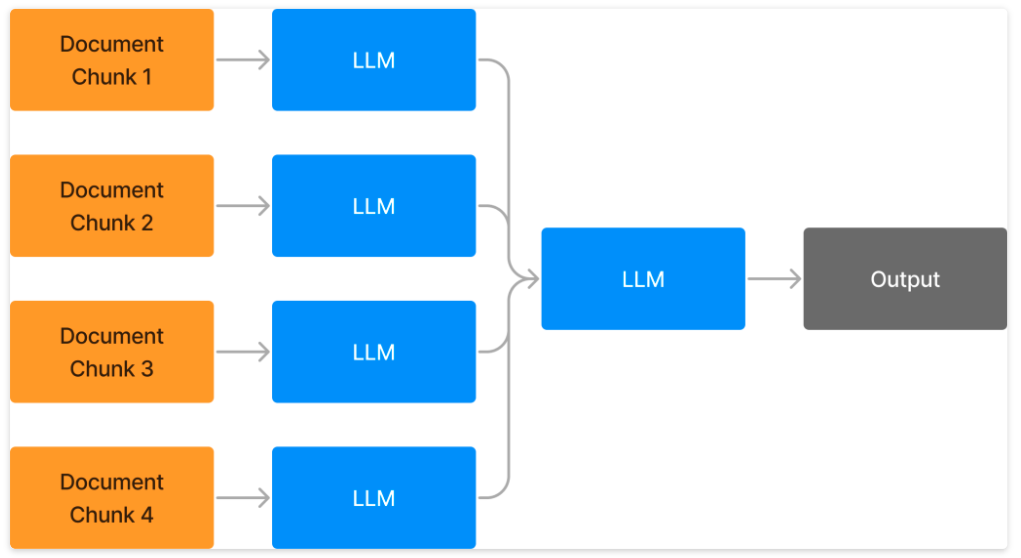

### LLM

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

### Basic example (short documents)

In [ ]:
from langchain_core.documents import Document

documents = [
    Document(page_content="Apples are red", metadata={"title": "apple_book"}),
    Document(page_content="Blueberries are blue", metadata={"title": "blueberry_book"}),
    Document(page_content="Bananas are yelow", metadata={"title": "banana_book"}),
]

In [ ]:
documents

[Document(metadata={'title': 'apple_book'}, page_content='Apples are red'),
 Document(metadata={'title': 'blueberry_book'}, page_content='Blueberries are blue'),
 Document(metadata={'title': 'banana_book'}, page_content='Bananas are yelow')]

In [ ]:
import operator
from typing import Annotated, List, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

map_template = "Write a concise summary of the following: {context}."

map_prompt = ChatPromptTemplate([("human", map_template)])
map_chain = map_prompt | llm | StrOutputParser()

In [ ]:
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])
reduce_chain = reduce_prompt | llm | StrOutputParser()

In [ ]:
# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}

In [ ]:
# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    final_summary: str

# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["summaries"])
    return {"final_summary": response}

In [ ]:
# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)

graph.add_node("generate_summary", generate_summary)
graph.add_node("generate_final_summary", generate_final_summary)

graph.add_conditional_edges(START,
                            map_summaries,
                             ["generate_summary"])

graph.add_edge("generate_summary", "generate_final_summary")
graph.add_edge("generate_final_summary", END)

app = graph.compile()

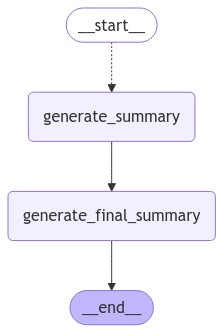

In [ ]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [ ]:
# Call the graph:
async for step in app.astream({"contents": [doc.page_content for doc in documents]}):
    print(step)

{'generate_summary': {'summaries': ['Blueberries are a blue-colored fruit.']}}
{'generate_summary': {'summaries': ['Bananas are yellow.']}}
{'generate_summary': {'summaries': ['Apples are characterized by their red color.']}}
{'generate_final_summary': {'final_summary': 'Fruits are often identified by their distinct colors, such as apples being red, blueberries being blue, and bananas being yellow.'}}


### Summarizing long documents

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import CharacterTextSplitter

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
documents = loader.load()

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(documents)
print(f"Generated {len(split_docs)} documents.")

Generated 14 documents.


In [ ]:
from typing import Literal

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)

In [ ]:
class OverallState(TypedDict):
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]  # add key for collapsed summaries
    final_summary: str


# Add node to store summaries for collapsing
def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


# Modify final summary to read off collapsed summaries
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["collapsed_summaries"])
    return {"final_summary": response}

In [ ]:
token_max = 1000

def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)

# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

    return {"collapsed_summaries": results}

In [ ]:
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"

In [ ]:
graph = StateGraph(OverallState)

graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("generate_final_summary", generate_final_summary)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

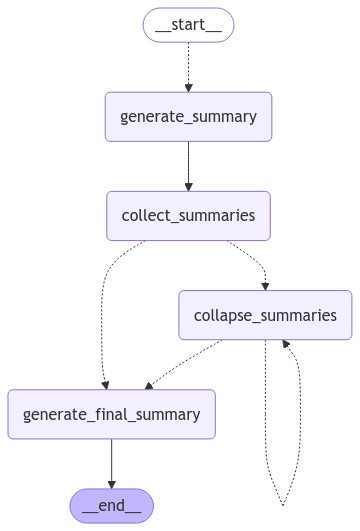

In [ ]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [ ]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['collapse_summaries']
['generate_final_summary']


## [MapRerankDocumentsChain](https://python.langchain.com/docs/versions/migrating_chains/map_rerank_docs_chain/)
- Map Re-rank 방법을 이용해 4개의 chunk로 나눈 문서에서 질문에 대한 답을 찾는 과정을 생각해봅시다.
  - 1번부터 4번까지의 Chunk에서 각각 답을 찾습니다. 이 때 답에 대해 확신하는 정도를 점수로 나타냅니다.
  - 확신 점수가 가장 높은 답을 결과로 채택합니다.
  
이 방법은 Map Reduce 방법에 비하면 API 호출 횟수가 적지만, 몇 개의 Chunk에 걸쳐 답에 관한 정보가 나눠져 있을 경우 이 정보들을 조합해서 답을 찾을 수는 없습니다.

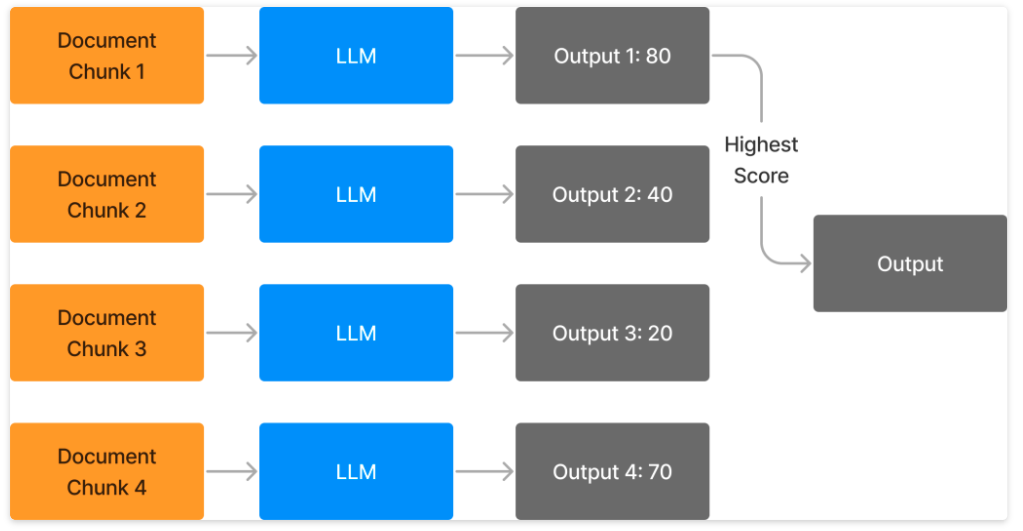

In [ ]:
import operator
from typing import Annotated, List, TypedDict

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

### Document

In [ ]:
from langchain_core.documents import Document

documents = [
    Document(page_content="Alice has blue eyes", metadata={"title": "book_chapter_2"}),
    Document(page_content="Bob has brown eyes", metadata={"title": "book_chapter_1"}),
    Document(
        page_content="Charlie has green eyes", metadata={"title": "book_chapter_3"}
    ),
]

### ChatPromptTemplate

In [ ]:
prompt_template = "What color are Bob's eyes?\n\n" "Context: {context}"
prompt = ChatPromptTemplate.from_template(prompt_template)

### LLM

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### chain

In [ ]:
class AnswerWithScore(TypedDict):
    answer: str
    score: Annotated[int, ..., "Score from 1-10."]

In [ ]:
# The below chain formats context from a document into a prompt, then
# generates a response structured according to the AnswerWithScore schema.
map_chain = prompt | llm.with_structured_output(AnswerWithScore)

### StateGraph

In [ ]:
# This will be the overall state of the graph.
# It will contain the input document contents, corresponding
# answers with scores, and a final answer.
class State(TypedDict):
    contents: List[str]
    answers_with_scores: Annotated[list, operator.add]
    answer: str

# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_analyses(state: State):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_analysis", {"content": content}) for content in state["contents"]
    ]

# Here we will select the top answer
def pick_top_ranked(state: State):
    ranked_answers = sorted(
        state["answers_with_scores"], key=lambda x: -int(x["score"])
    )
    return {"answer": ranked_answers[0]}

In [ ]:
# This will be the state of the node that we will "map" all
# documents to in order to generate answers with scores
class MapState(TypedDict):
    content: str

# Here we generate an answer with score, given a document
async def generate_analysis(state: MapState):
    response = await map_chain.ainvoke(state["content"])
    return {"answers_with_scores": [response]}

In [ ]:
# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(State)

graph.add_node("generate_analysis", generate_analysis)
graph.add_node("pick_top_ranked", pick_top_ranked)
graph.add_conditional_edges(START, map_analyses, ["generate_analysis"])
graph.add_edge("generate_analysis", "pick_top_ranked")
graph.add_edge("pick_top_ranked", END)

app = graph.compile()

### display

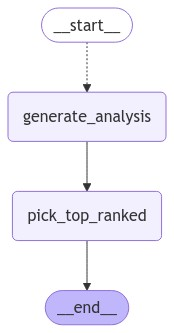

In [ ]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

### app.ainvoke

In [ ]:
result = await app.ainvoke({"contents": [doc.page_content for doc in documents]})
result["answer"]

{'answer': "Bob's eyes are brown.", 'score': 10}

## [LLMRouterChain](https://python.langchain.com/docs/versions/migrating_chains/llm_router_chain/)

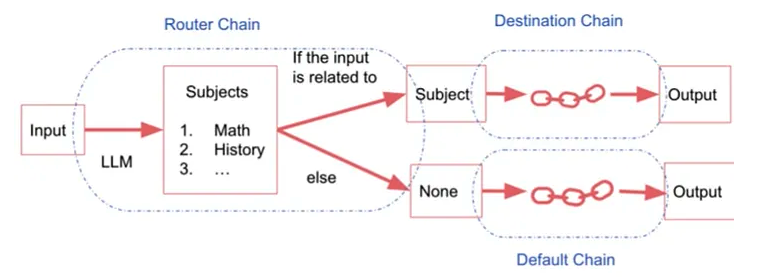

In [ ]:
from operator import itemgetter
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

### LLM

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

### ChatPromptTemplate

In [ ]:
route_system = "Route the user's query to either the animal or vegetable expert."
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", route_system),
        ("human", "{input}"),
    ]
)

### RouteQuery

In [ ]:
# Define schema for output:
class RouteQuery(TypedDict):
    """Route query to destination expert."""

    destination: Literal["animal", "vegetable"]

### chain

In [ ]:
# Instead of writing formatting instructions into the prompt, we
# leverage .with_structured_output to coerce the output into a simple
# schema.
chain = route_prompt | llm.with_structured_output(RouteQuery)

In [ ]:
result = chain.invoke({"input": "What color are carrots?"})

print(result["destination"])

vegetable


## [MultiPromptChain](https://python.langchain.com/docs/versions/migrating_chains/multi_prompt_chain/)

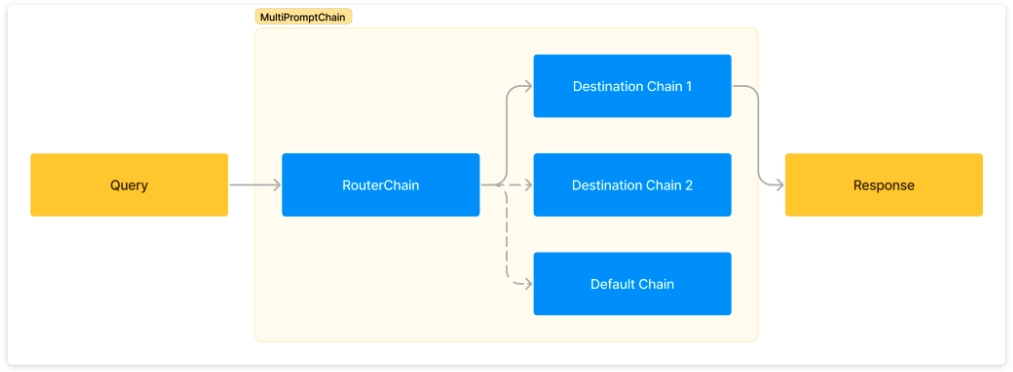

In [ ]:
from operator import itemgetter
from typing import Literal

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict

### LLM

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

### chain

In [ ]:
# Define the prompts we will route to
prompt_1 = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an expert on animals."),
        ("human", "{input}"),
    ]
)

chain_1 = prompt_1 | llm | StrOutputParser()

In [ ]:
prompt_2 = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an expert on vegetables."),
        ("human", "{input}"),
    ]
)

chain_2 = prompt_2 | llm | StrOutputParser()

In [ ]:
# Next: define the chain that selects which branch to route to.
# Here we will take advantage of tool-calling features to force
# the output to select one of two desired branches.
route_system = "Route the user's query to either the animal or vegetable expert."
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", route_system),
        ("human", "{input}"),
    ]
)


# Define schema for output:
class RouteQuery(TypedDict):
    """Route query to destination expert."""

    destination: Literal["animal", "vegetable"]


route_chain = route_prompt | llm.with_structured_output(RouteQuery)

### StateGraph

In [ ]:
# For LangGraph, we will define the state of the graph to hold the query,
# destination, and final answer.
class State(TypedDict):
    query: str
    destination: RouteQuery
    answer: str


# We define functions for each node, including routing the query:
async def route_query(state: State, config: RunnableConfig):
    destination = await route_chain.ainvoke(state["query"], config)
    return {"destination": destination}


# And one node for each prompt
async def prompt_1(state: State, config: RunnableConfig):
    return {"answer": await chain_1.ainvoke(state["query"], config)}


async def prompt_2(state: State, config: RunnableConfig):
    return {"answer": await chain_2.ainvoke(state["query"], config)}


# We then define logic that selects the prompt based on the classification
def select_node(state: State) -> Literal["prompt_1", "prompt_2"]:
    if state["destination"] == "animal":
        return "prompt_1"
    else:
        return "prompt_2"

In [ ]:
# Finally, assemble the multi-prompt chain. This is a sequence of two steps:
# 1) Select "animal" or "vegetable" via the route_chain, and collect the answer
# alongside the input query.
# 2) Route the input query to chain_1 or chain_2, based on the
# selection.
graph = StateGraph(State)

graph.add_node("route_query", route_query)
graph.add_node("prompt_1", prompt_1)
graph.add_node("prompt_2", prompt_2)
graph.add_edge(START, "route_query")
graph.add_conditional_edges("route_query", select_node)
graph.add_edge("prompt_1", END)
graph.add_edge("prompt_2", END)

app = graph.compile()

### display

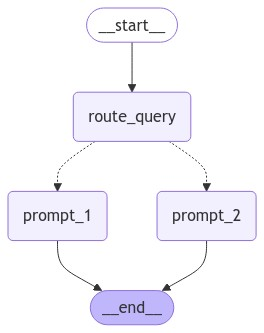

In [ ]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

### app

In [ ]:
state = await app.ainvoke({"query": "what color are carrots"})
print(state["destination"])
print(state["answer"])

{'destination': 'vegetable'}
Carrots are most commonly orange, but they can also come in a variety of other colors including purple, red, yellow, and white. The color of a carrot is influenced by its variety and the presence of different pigments, such as beta-carotene in orange carrots, anthocyanins in purple carrots, and lutein in yellow carrots.
